# 0.0 IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [8]:
# Whats is low_memory?
df_raw = pd.read_csv('https://media.githubusercontent.com/media/panambY/Used_Car_Price/master/data/vehicles.csv', low_memory=False, error_bad_lines=False)

In [9]:
df_raw.sample()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
330944,7115356693,https://anchorage.craigslist.org/ctd/d/anchora...,anchorage / mat-su,https://anchorage.craigslist.org,36890,2019.0,toyota,4-runner,NaN,NaN,gas,15300.0,clean,automatic,JTEBU5JR8K5675636,4wd,NaN,wagon,red,https://images.craigslist.org/01414_aRpFlGDKvy...,2019 Toyota 4Runner TRD Off Road Premium 4x4 4...,NaN,ak,61.1867,-149.915


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [10]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [11]:
df1.columns

# The columns already have a label that I want and easy to understand.

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

## 1.2 Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 435849
Number of Cols: 25


## 1.3 Data Types

In [13]:
df1.dtypes
# At first, the types of the variables are corrected.

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
vin              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
dtype: object

## 1.4. Check NA

In [14]:
df1.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1117
manufacturer     20747
model             6199
condition       186806
cylinders       166384
fuel              2991
odometer         75148
title_status      1806
transmission      2146
vin             196652
drive           122011
size            295961
type            117108
paint_color     135247
image_url           24
description         27
county          435849
state                0
lat               8235
long              8235
dtype: int64

## 1.5 Fillout NA

In [15]:
# --> year

# The first variable that has an empty value and that I will deal with is the "year".
# Looking at the other variables to be able to see if I can extract some info that helps to fill in the "nan" values, I find that the "description" column has the info year inside it.
# The problem is that there are also "nan" values in the "description" column. The positive info is that there are only 27 empty values in the "description" column.
# I only looked at the observations where "description" is empty and found that, of the 27 empty values, 3 already have the "year" column filled in and the rest have almost no value filled in the other columns.
# My solution is as follows: fill the column "year" with the information contained in the column "description" not empty and drop the entire line in the 24 observations where the column "description" is empty along with several others, as we will not have enough info.
# First of all, I will drop the rows where the columns "year" and "description" are null.
df1.dropna(subset=['year', 'description'], how='all', inplace=True)
df1['year'] = df1.apply( lambda x: x['description'][:5] if math.isnan( x['year'] ) else x['year'], axis=1 )
# After fill the nan values in "year" column, there are some values that aren't year values, such as: '92 to', '03 je', 'Auto' and 'Nice'. I will transform these values by hand.
df1['year'] = df1.apply( lambda x: 1992 if x['year']=='92 to' else x['year'], axis=1 ) # We can see easily that the year is "1992"
df1['year'] = df1.apply( lambda x: 2003 if x['year']=='03 je' else x['year'], axis=1 ) # We can see easily that the year is "2003"
df1.drop(df1.loc[df1['year']=='Auto '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.
df1.drop(df1.loc[df1['year']=='Nice '].index, inplace=True) # In the description columns don't have any info about the year; so, we will drop the entire row.

# --> manufacturer

# I noticed that the "description" and "model" columns have info that can help me fill in the "manufacturer" column.
# How to get the info from the "description" column will be more work at first, I'll try to do a "to" from the "model" column to fill in the "manufacturer" column.
df1['model'] = df1['model'].str.lower() # First I will apply a lower function in the "model" column.
# In the first cicle I will drop que rows that have 'model' and 'manufacturer' with nan values at the same time.
df1.drop( index=df1[df1['manufacturer'].isna() & df1['model'].isna()].index, inplace=True )
# Now I will create a dictionary with the model and its respective manufacturer.
df11 = df1[df1['manufacturer'].notna()]
df12 = df11[df11['model'].notna()]
manufacturer_dict = {}
for k, v in df12[['model', 'manufacturer']].values:
    manufacturer_dict[k] = v
df1['manufacturer'] = df1.apply( lambda x: manufacturer_dict[x['model']] if x['model'] in manufacturer_dict.keys() else x['manufacturer'], axis=1) # reduce the "nan" values to 17848, but not resolved.
# The second attempt to decrease or end "nan" values will be to take the list of manufacturers and check if they are present in the "description" column.
df1['description'] = df1['description'].str.lower()
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['description'] ) or pd.notna( x['manufacturer'] )
                                else 'ford' if 'ford' in str(x['description']).split() 
                                else 'chevrolet' if 'chevrolet' in str(x['description']).split() 
                                else 'toyota' if 'toyota' in str(x['description']).split() 
                                else 'nissan' if 'nissan' in str(x['description']).split() 
                                else 'honda' if 'honda' in str(x['description']).split()
                                else 'jeep' if 'jeep' in str(x['description']).split() 
                                else 'gmc' if 'gmc' in str(x['description']).split() 
                                else 'ram' if 'ram' in str(x['description']).split() 
                                else 'dodge' if 'dodge' in str(x['description']).split() 
                                else 'mercedes-benz' if 'mercedes-benz' in str(x['description']).split() 
                                else 'bmw' if 'bmw' in str(x['description']).split() 
                                else 'hyundau' if 'hyundai' in str(x['description']).split() 
                                else 'subaru' if 'subaru' in str(x['description']).split() 
                                else 'volkswagen' if 'volkswagen' in str(x['description']).split() 
                                else 'kia' if 'kia' in str(x['description']).split()
                                else 'chrysler' if 'chrysler' in str(x['description']).split() 
                                else 'cadillac' if 'cadillac' in str(x['description']).split() 
                                else 'lexus' if 'lexus' in str(x['description']).split() 
                                else 'buick' if 'buick' in str(x['description']).split() 
                                else 'mazda' if 'mazda' in str(x['description']).split()
                                else 'audi' if 'audi' in str(x['description']).split() 
                                else 'acura' if 'acura' in str(x['description']).split() 
                                else 'infiniti' if 'infiniti' in str(x['description']).split() 
                                else 'lincoln' if 'lincoln' in str(x['description']).split() 
                                else 'pontiac' if 'pontiac' in str(x['description']).split()
                                else 'volvo' if 'volvo' in str(x['description']).split() 
                                else 'mitsubishi' if 'mitsubishi' in str(x['description']).split() 
                                else 'mini' if 'mini' in str(x['description']).split() 
                                else 'rover' if 'rover' in str(x['description']).split() 
                                else 'mercury' if 'mercury' in str(x['description']).split() 
                                else 'saturn' if 'saturn' in str(x['description']).split() 
                                else 'fiat' if 'fiat' in str(x['description']).split() 
                                else 'jaguar' if 'jaguar' in str(x['description']).split() 
                                else 'tesla' if 'tesla' in str(x['description']).split() 
                                else 'harley-davidson' if 'harley-davidson' in str(x['description']).split()
                                else 'ferrari' if 'ferrari' in str(x['description']).split() 
                                else 'alfa-romeo' if 'alfa-romeo' in str(x['description']).split() 
                                else 'datsun' if 'datsun' in str(x['description']).split() 
                                else 'aston-martin' if 'aston-martin' in str(x['description']).split() 
                                else 'porche' if 'porche' in str(x['description']).split()
                                else 'land rover' if 'land rover' in str(x['description']).split() 
                                else 'morgan' if 'morgan' in str(x['description']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 12514, but not resolved.
# The third and last attempt I will see the values in "model" columns and find a relationtionship between "manufacturer" and "model".
df1['manufacturer'] = df1.apply( lambda x: x['manufacturer'] if pd.isna( x['model'] ) or pd.notna( x['manufacturer'] )
                                else 'gmc' if 'hummer' in str(x['model']).split() 
                                else 'ford' if 'freightliner' in str(x['model']).split() 
                                else 'volkswagen' if 'porsche' in str(x['model']).split() 
                                else 'isuzu' if 'isuzu' in str(x['model']).split() 
                                else 'navistar' if 'internacional ' in str(x['model']).split() 
                                else 'gmc' if 'saab' in str(x['model']).split() 
                                else 'suzuki' if 'suzuki' in str(x['model']).split() 
                                else 'paccar' if 'peterbilt' in str(x['model']).split()
                                else 'volkswagen' if 'jetta' in str(x['model']).split()
                                else 'paccar' if 'kenworth' in str(x['model']).split()
                                else 'chrysler' if 'plymouth' in str(x['model']).split()
                                else 'gmc' if 'oldsmobile' in str(x['model']).split()
                                else 'volkswagen' if 'bentley' in str(x['model']).split()
                                else 'toyota' if 'hino' in str(x['model']).split()
                                else 'gmc' if 'janesville' in str(x['model']).split()
                                else 'bmw' if 'triumph' in str(x['model']).split()
                                else 'chrysler' if 'maserati' in str(x['model']).split()
                                else 'volkswagen' if 'lamborghini' in str(x['model']).split()
                                else 'chevrolet' if 'corvette' in str(x['model']).split()
                                else 'gmc' if 'caddilac' in str(x['model']).split()
                                else 'chevrolet' if 'cheverolet' in str(x['model']).split()
                                else 'hyundau' if 'hyunday' in str(x['model']).split()
                                else 'hyundau' if 'hyundai' in str(x['model']).split()
                                else 'chevrolet' if 'chevorlet' in str(x['model']).split()
                                else 'volkswagen' if 'volkswagon' in str(x['model']).split()
                                else x['manufacturer'], axis=1 ) # reduce the "nan" values to 6068, but not resolved. Thats enought for the first cicle. From the second cycle I can treat data better.
# In the rest of the values in "manufacturer" column I will input a 'unknown' value.
df1['manufacturer'].fillna( 'unknown', inplace=True )

# --> condition

# Check if you have a model with the "condition" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['condition'].notna()]
df12 = df11[df11['model'].notna()]
condition_dict = {}
for k, v in df12[['model', 'condition']].values:
    condition_dict[k] = v
df1['condition'] = df1.apply( lambda x: x['condition'] if pd.isna( x['model'] ) or pd.notna( x['condition'] ) else condition_dict[x['model']] if x['model'] in condition_dict.keys() else x['condition'], axis=1)# 28615 "nan" values left.
# as it can cause confusion between the "like new" and "new" values I will not try to fill in the "nan" values using the ifo's in the "description" variable.
# For the remaining "nan" values, enter the "unknown" value.
df1['condition'].fillna( 'unknown', inplace=True )

# --> cylinders

# Check if you have a model with the "cylinders" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['cylinders'].notna()]
df12 = df11[df11['model'].notna()]
cylinders_dict = {}
for k, v in df12[['model', 'cylinders']].values:
    cylinders_dict[k] = v
df1['cylinders'] = df1.apply( lambda x: x['cylinders'] if pd.isna( x['model'] ) or pd.notna( x['cylinders'] ) else cylinders_dict[x['model']] if x['model'] in cylinders_dict.keys() else x['cylinders'], axis=1)# 29022 "nan" values remain.
# Since the values inside the "cylinders" variable have space between them, they can cause errors in filling in the "nan" values using the "split" function.
# For the remaining "nan" values, enter the "unknown" value.
df1['cylinders'].fillna( 'unknown', inplace=True )

# --> fuel

# As it can happen that the same car model has several possibilities for "fuel" I will not use the search formula in the "model" variable.
# Check and there is a "fuel" value within the "description" variable. In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['fuel'] = df1.apply( lambda x: x['fuel'] if pd.isna( x['description'] ) or pd.notna( x['fuel'] )
                                else 'gas' if 'gas' in str(x['description']).split() 
                                else 'diesel' if 'diesel' in str(x['description']).split() 
                                else 'hybrid' if 'hybrid' in str(x['description']).split() 
                                else 'electric' if 'electric' in str(x['description']).split()
                                else x['fuel'], axis=1 ) # 2152 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['fuel'].fillna( 'unknown', inplace=True )

# --> odometer

# Trying to stipulate the value as close to reality as possible, I will fill in the "nan" values by separating this variable by the "year" column and calculating the median to try to prevent the value from being affected by possible outliers.
df1['odometer'] = df1['odometer'].fillna(df1.groupby('year')['odometer'].transform('median'))
# Since there are only 40 empty values left, I will drop all 40 lines that have "nan" values in the "odometer" column.
df1.drop(df1[df1['odometer'].isna()].index, inplace=True)

# --> title_status

# Since the values of this variable are difficult to identify effectively through queries to other columns and the total "nan" values are low, I will directly fill in the "nan" values with "unknown".
df1['title_status'].fillna( 'unknow', inplace=True )

# --> transmission

# As it can happen that the same car model has several transmission possibilities, I will not use the search formula in the variable "model".
# Check and there is the value of "transmission" inside the variable "description". In order not to cause an error in filling in the "nan" values, I will not use the "other" value.
df1['transmission'] = df1.apply( lambda x: x['transmission'] if pd.isna( x['description'] ) or pd.notna( x['transmission'] )
                                else 'automatic' if 'automatic' in str(x['description']).split() 
                                else 'manual' if 'manual' in str(x['description']).split()
                                else x['transmission'], axis=1 ) # 1812 "nan" values remain.
# For the remaining "nan" values, enter the "unknown" value.
df1['transmission'].fillna( 'unknow', inplace=True )

# --> drive

# Check if you have a model with the "drive" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['drive'].notna()]
df12 = df11[df11['model'].notna()]
drive_dict = {}
for k, v in df12[['model', 'drive']].values:
    drive_dict[k] = v
df1['size'] = df1.apply( lambda x: x['drive'] if pd.isna( x['model'] ) or pd.notna( x['drive'] ) else drive_dict[x['model']] if x['model'] in drive_dict.keys() else x['drive'], axis=1)# 18125 "nan" values remain.
# Check and there is a "drive" value inside the "description" variable.
df1['drive'] = df1.apply( lambda x: x['drive'] if pd.isna( x['description'] ) or pd.notna( x['drive'] )
                                else '4wd' if '4wd' in str(x['description']).split() 
                                else 'fwd' if 'fwd' in str(x['description']).split() 
                                else 'rwd' if 'rwd' in str(x['description']).split() 
                                else x['drive'], axis=1 ) # did not fill in any "nan" values.
# For the remaining "nan" values, enter the "unknown" value.
df1['drive'].fillna( 'unknow', inplace=True )

# --> size

# Check if you have a model with the "size" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['size'].notna()]
df12 = df11[df11['model'].notna()]
size_dict = {}
for k, v in df12[['model', 'size']].values:
    size_dict[k] = v
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['model'] ) or pd.notna( x['size'] ) else size_dict[x['model']] if x['model'] in size_dict.keys() else x['size'], axis=1)
# Check and there is a "size" value inside the "description" variable.
df1['size'] = df1.apply( lambda x: x['size'] if pd.isna( x['description'] ) or pd.notna( x['size'] )
                                else 'full-size' if 'full-size' in str(x['description']).split() 
                                else 'mid-size' if 'mid-size' in str(x['description']).split() 
                                else 'compact' if 'compact' in str(x['description']).split() 
                                else 'sub-compact' if 'sub-compact' in str(x['description']).split() 
                                else x['size'], axis=1 )
# For the remaining "nan" values, enter the "unknown" value.
df1['size'].fillna( 'unknow', inplace=True )

# --> type

# Check if you have a model with the "type" filled in that can help us complete the "nan" values that have the same model.
df11 = df1[df1['type'].notna()]
df12 = df11[df11['model'].notna()]
type_dict = {}
for k, v in df12[['model', 'type']].values:
    type_dict[k] = v
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['model'] ) or pd.notna( x['type'] ) else type_dict[x['model']] if x['model'] in type_dict.keys() else x['type'], axis=1)# 17472 "nan" values remain.
# Check and there is the value of "type" inside the variable "description".
df1['type'] = df1.apply( lambda x: x['type'] if pd.isna( x['description'] ) or pd.notna( x['type'] )
                                else 'SUV' if 'SUV' in str(x['description']).split() 
                                else 'sedan' if 'sedan' in str(x['description']).split() 
                                else 'pickup' if 'pickup' in str(x['description']).split() 
                                else 'truck' if 'truck' in str(x['description']).split() 
                                else 'coupe' if 'coupe ' in str(x['description']).split() 
                                else 'hatchback' if 'hatchback' in str(x['description']).split() 
                                else 'van' if 'van' in str(x['description']).split() 
                                else 'wagon' if 'wagon' in str(x['description']).split()
                                else 'convertible' if 'convertible' in str(x['description']).split()
                                else 'mini-van' if 'mini-van' in str(x['description']).split()
                                else 'offroad' if 'offroad' in str(x['description']).split()
                                else 'bus' if 'bus' in str(x['description']).split()
                                else x['type'], axis=1 )# 10685 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['type'].fillna( 'unknow', inplace=True )

# --> paint-color

# As it can happen that the same car model has several possibilities of "paint-color" I will not use the search formula in the variable "model".
# Check and there is the value of "paint-color" inside the variable "description".
df1['paint_color'] = df1.apply( lambda x: x['paint_color'] if pd.isna( x['description'] ) or pd.notna( x['paint_color'] )
                                else 'white' if 'white' in str(x['description']).split() 
                                else 'black' if 'black' in str(x['description']).split() 
                                else 'silver' if 'silver' in str(x['description']).split() 
                                else 'blue' if 'blue' in str(x['description']).split() 
                                else 'grey' if 'grey ' in str(x['description']).split() 
                                else 'red' if 'red' in str(x['description']).split() 
                                else 'green' if 'green' in str(x['description']).split() 
                                else 'custom' if 'custom' in str(x['description']).split()
                                else 'brown' if 'brown' in str(x['description']).split()
                                else 'yellow' if 'yellow' in str(x['description']).split()
                                else 'orange' if 'orange' in str(x['description']).split()
                                else 'purple' if 'purple' in str(x['description']).split()
                                else x['paint_color'], axis=1 ) # 89241 "nan" values left.
# For the remaining "nan" values, enter the "unknown" value.
df1['paint_color'].fillna( 'unknow', inplace=True )

# --> lat and long

# Since "lat" and "long" are directly related to "region" I will separate them by "region" and average "lat" and "long".
# Here, unlike what was done in the "odometer" variable, there is no need to use the median because the variation in this case will be very small.
df1['lat'] = df1['lat'].fillna(df1.groupby('region')['lat'].transform('mean'))
df1['long'] = df1['long'].fillna(df1.groupby('region')['long'].transform('mean')) # no missing values left.

# --> id

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['id'], axis=1, inplace=True )

# --> url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['url'], axis=1, inplace=True )

# --> region_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['region_url'], axis=1, inplace=True )

# --> model

# That column has a lot of polluted data and it would take months of work to try to correct it one by one. As I have a lot of variables with good potentials in this dataset I will choose to drop this column. 
# If the model does not perform well in the end, in the next cycles I will study the possibility of treating this column better.
# I think it is worse for the project to delete only the nan rows, but keeping the column, than to delete the entire column and not decrease the number of observations in our dataset.
df1.drop( ['model'], axis=1, inplace=True )

# --> vin

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['vin'], axis=1, inplace=True )

# --> image_url

# This variable is not relevant to the project. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['image_url'], axis=1, inplace=True )

# --> description

# This variable is not relevant to the project, but it was extremely important in helping to fill in the "nan" values in other columns. So I will not deal with your "nan" values and I will drop this column.
df1.drop( ['description'], axis=1, inplace=True )

# --> county

# All the "county" column have null value. I will drop this column.
df1.drop( ['county'], axis=1, inplace=True )

In [16]:
df1.isna().sum()

region          0
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
lat             0
long            0
dtype: int64

## 1.6 Change Types

In [17]:
# Check if, after the treatment of the "nan" values, there was any problem of data types.
df1.dtypes

region           object
price             int64
year             object
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

In [18]:
# year
df1['year'] = df1['year'].astype( 'int64' )

In [19]:
# That's all correct!
df1.dtypes

region           object
price             int64
year              int64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [21]:
num_attributes.sample()

,price,year,odometer,lat,long
38049,10990,2014,53130.0,33.84,-84.38


In [22]:
cat_attributes.sample()

,region,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
146650,vermont,jeep,excellent,6 cylinders,gas,clean,automatic,unknow,4wd,SUV,unknow,vt


### 1.7.1 Numerical Attributes

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [24]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,0.0000,3.647257e+09,3.647257e+09,134933.370712,9995.0000,1.690999e+07,158.461034,26817.493962
1,year,1900.0000,2.021000e+03,1.210000e+02,2009.891472,2012.0000,9.297403e+00,-3.571246,19.998197
2,odometer,0.0000,1.000000e+07,1.000000e+07,100359.163605,95075.0000,1.057850e+05,43.668401,3584.123534
3,lat,-83.1971,7.960190e+01,1.627990e+02,38.384713,38.8840,6.002674e+00,-0.371858,7.649340
4,long,-177.0120,1.736750e+02,3.506870e+02,-94.772707,-89.2975,1.799597e+01,-0.703751,1.196016


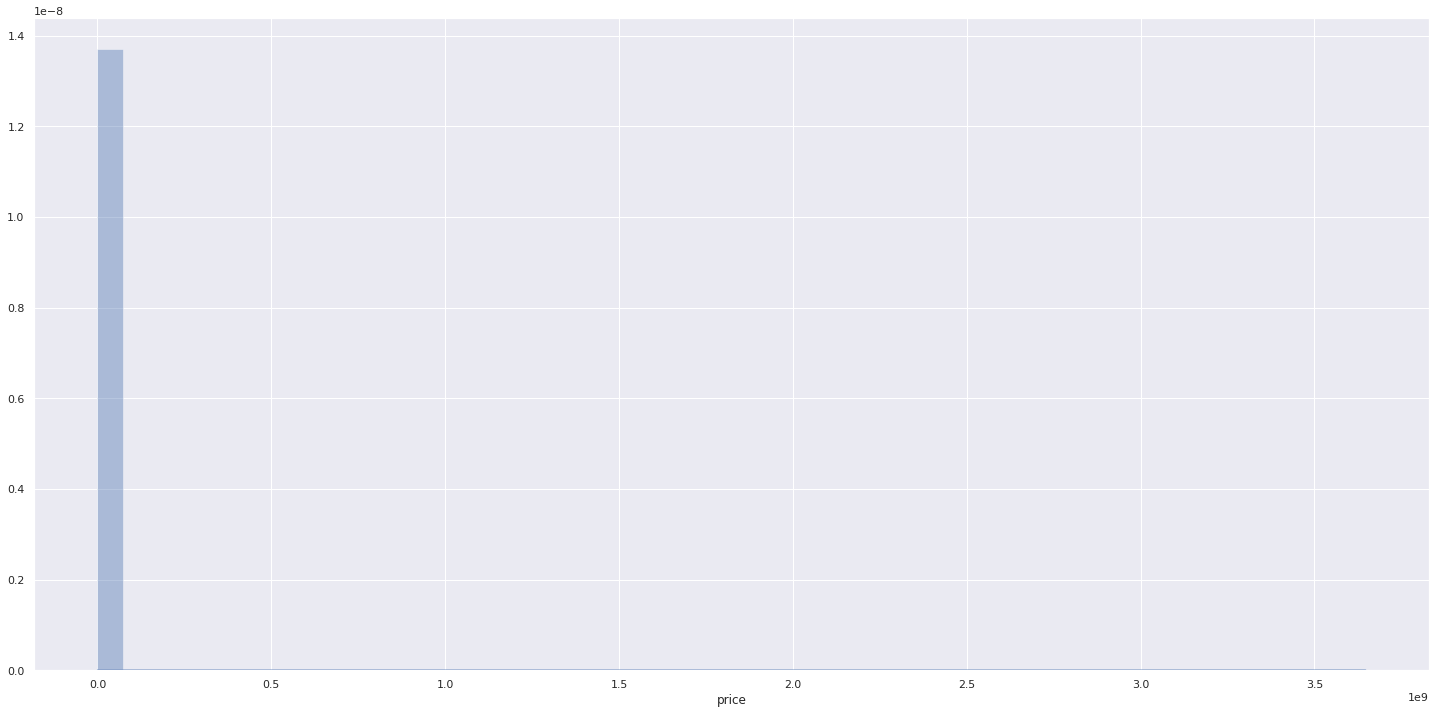

In [25]:
sns.distplot( df1['price'] )
# Observing the distribution of the target variable, we can already see the presence of outliers. This problem will be addressed later.

### 1.7.2. Categorical Attributes

In [26]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

region          403
manufacturer     47
condition         7
cylinders         9
fuel              6
title_status      7
transmission      4
drive             4
size              8
type             14
paint_color      13
state            51
dtype: int64

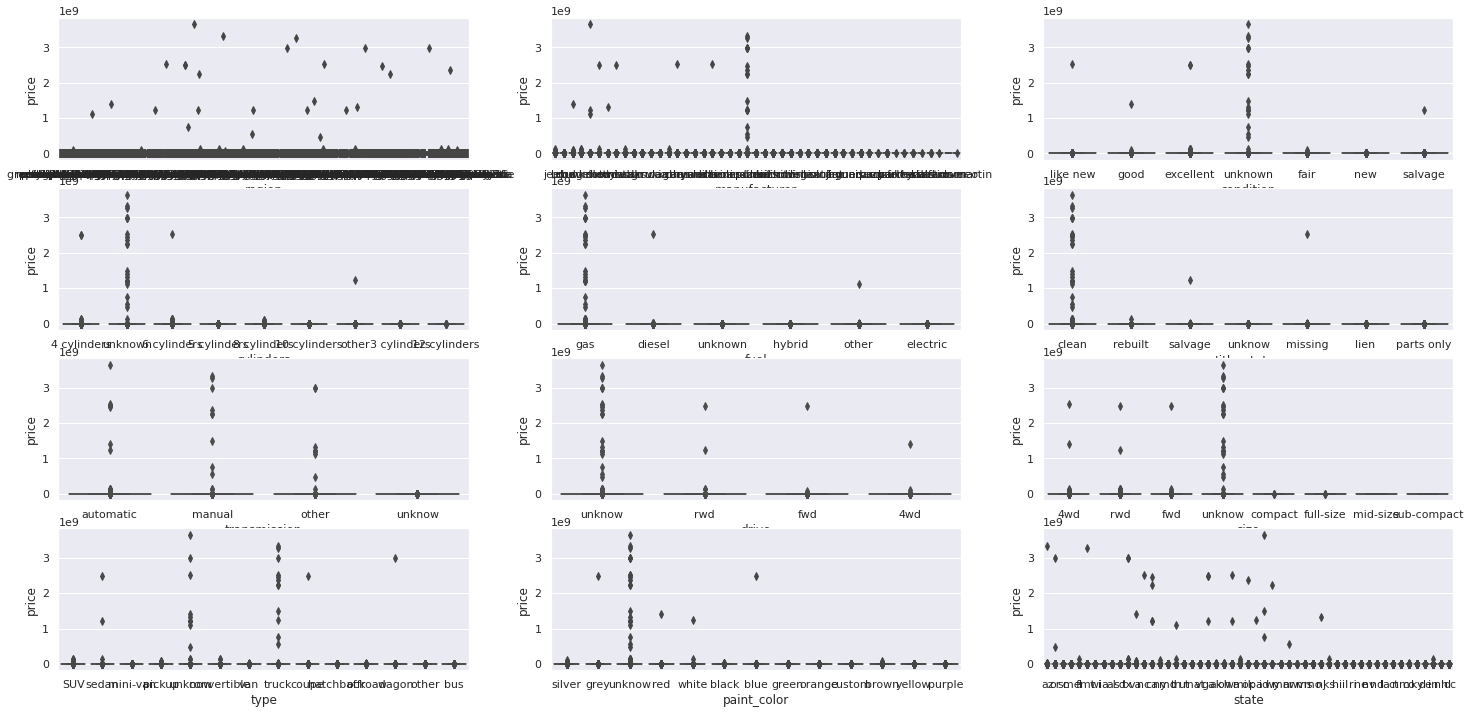

In [27]:
aux1 = df1[ df1['price'] > 0 ]


plt.subplot(4, 3, 1)
sns.boxplot( x= 'region', y='price' , data=aux1 )

plt.subplot(4, 3, 2)
sns.boxplot( x= 'manufacturer', y='price' , data=aux1 )

plt.subplot(4, 3, 3)
sns.boxplot( x= 'condition', y='price' , data=aux1 )

plt.subplot(4, 3, 4)
sns.boxplot( x= 'cylinders', y='price' , data=aux1 )

plt.subplot(4, 3, 5)
sns.boxplot( x= 'fuel', y='price' , data=aux1 )

plt.subplot(4, 3, 6)
sns.boxplot( x= 'title_status', y='price' , data=aux1 )

plt.subplot(4, 3, 7)
sns.boxplot( x= 'transmission', y='price' , data=aux1 )

plt.subplot(4, 3, 8)
sns.boxplot( x= 'drive', y='price' , data=aux1 )

plt.subplot(4, 3, 9)
sns.boxplot( x= 'size', y='price' , data=aux1 )

plt.subplot(4, 3, 10)
sns.boxplot( x= 'type', y='price' , data=aux1 )

plt.subplot(4, 3, 11)
sns.boxplot( x= 'paint_color', y='price' , data=aux1 )

plt.subplot(4, 3, 12)
sns.boxplot( x= 'state', y='price' , data=aux1 )

# The same thing observed in the numerical data can be found in the ategorical data as well: The strong presence of outliers in the dataset. 
# It is even difficult to visualize the distribution of categorical variables.

# 2.0 STEP 02 - FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

In [29]:
Image( "https://github.com/panambY/Used_Car_Price/blob/master/image/Hyphoteses_Map.png")

## 2.1 Creation of Hyphoteses

### 2.1.1 Condition Hyphoteses

**1.** Painting

**2.** Interior with good condition has higher price

**3.** Used cars with high Mailage has lower price.

**4.** Appearance

**5.** Mechanical

**6.** Insurance

### 2.1.2 Location Hyphoteses

**1.** Neighborhood

**2.** Region

**3.** District

**4.** City

**5.** State

**6.** Urban

**7.** Rural

**8.** Country

### 2.1.3 Category Hyphoteses

**1.** Size

**2.** Manufacturer

**3.** Drive

**4.** Brand

**5.** Model

**6.** Segment

**7.** Fuel

**8.** Type

### 2.1.4 Acessories Hyphoteses

**1.** Transmission

**2.** Paint-color

**3.** High-end stereos

**4.** Airbags

**5.** Air-condition

**6.** Automatic pilot

**7.** Supercharger kits

**8.** Custom rims

**9.** Cylinders

### 2.1.5 Time Hyphoteses

**1.** Lat/Long

**2.** Lifetime

**3.** Age

**4.** Season

**5.** Holidays

### 2.1.6 Sales Channel Hyphoteses

**1.** Physical store

**2.** Online store

**3.** Owner

**4.** Middleman